### Loading Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV

import gensim
from gensim import corpora, models, similarities, matutils
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize,RegexpTokenizer

# spacy for lemmatization
#import spacy

import re

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

### Loading data and build LDA model

In [2]:
raw_data = pd.read_csv('Data2017.csv')
raw_data.head()

,reviews.rating,reviews.text,reviews_year
0,4.0,My sister came into town so we decided to go t...,2017
1,4.8,"Bad: The bed wasn't that comfy, which was surp...",2017
2,4.6,"Bad: Noisy in lower floors, but not at all at ...",2017
3,4.6,Good: Staff went out of their way after checko...,2017
4,4.8,Bad: A little bit of noise from the 'L' down b...,2017


In [3]:
# Negative reviews when rating is below 3
data_neg = raw_data[raw_data['reviews.rating'].apply(lambda x: x < 3)].reset_index(drop=True)
data_neg.head()

,reviews.rating,reviews.text,reviews_year
0,2.50,Staff weren't helpful and no one tried to come...,2017
1,2.50,Bad: The restaurant was closed for a refurb an...,2017
2,2.10,Bad: Thumping music all night long. So loud th...,2017
3,1.65,Bad: The room I booked was a non-smoking but w...,2017
4,2.50,"Bad: 1st - PARKING LOT **BAD,BAD,BAD** This is...",2017


In [4]:
# Text preprocessing steps - remove numbers, capital letters and punctuation
import re
import string

alphanumeric = lambda x: re.sub(r'\w*\d\w*', '', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())

data_neg['reviews.text'] = data_neg['reviews.text'].map(alphanumeric).map(punc_lower)
data_neg.head()

,reviews.rating,reviews.text,reviews_year
0,2.50,staff werent helpful and no one tried to come ...,2017
1,2.50,bad the restaurant was closed for a refurb and...,2017
2,2.10,bad thumping music all night long so loud the ...,2017
3,1.65,bad the room i booked was a nonsmoking but whe...,2017
4,2.50,bad parking lot badbadbad this is nobody ne...,2017


In [5]:
neg_reviews = data_neg['reviews.text'].values.tolist()
print(neg_reviews[:1])

['staff werent helpful and no one tried to come and clean our room on several nights rooms were very small good location']


In [6]:
# Tokenize and clean-up using gensim's simple_preprocess()
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(neg_reviews))
print(data_words[:1])

[['staff', 'werent', 'helpful', 'and', 'no', 'one', 'tried', 'to', 'come', 'and', 'clean', 'our', 'room', 'on', 'several', 'nights', 'rooms', 'were', 'very', 'small', 'good', 'location']]


In [7]:
# Create a CountVectorizer for parsing/counting words
vectorizer = CountVectorizer(stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")
data_vectorized = vectorizer.fit_transform(neg_reviews)

In [8]:
# Check the sparsicity
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.0882447305648166 %


In [9]:
# Build LDA model with sklearn
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [10]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -45760.320993691974
Perplexity:  392129.4564719164
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [11]:
# Use GridSearch to obtain best parameters
# Define Search Param
search_params = {'n_components': [4, 5, 6, 7, 8, 9, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [12]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 4}
Best Log Likelihood Score:  -7916.7380377934605
Model Perplexity:  1306.2869479734495


In [13]:
# Compare LDA model performance scores
# Get Log Likelyhoods from Grid Search Output
#n_components = [10, 15, 20, 25, 30]
#log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
#log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.7]
#log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.9]

# Show graph
#plt.figure(figsize=(12, 8))
#plt.plot(n_topics, log_likelyhoods_5, label='0.5')
#plt.plot(n_topics, log_likelyhoods_7, label='0.7')
#plt.plot(n_topics, log_likelyhoods_9, label='0.9')
#plt.title("Choosing Optimal LDA Model")
#plt.xlabel("Num Topics")
#plt.ylabel("Log Likelyhood Scores")
#plt.legend(title='Learning decay', loc='best')
#plt.show()

In [14]:
# How to see dominant topic in each document
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(neg_reviews))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Get the negative reviews printed
for i in range(0,len(neg_reviews),1):
    print("Negative reviews " + str(i) + ": " + neg_reviews[i] + "\n")

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(40).style.applymap(color_green).applymap(make_bold)
df_document_topics

Negative reviews 0: staff werent helpful and no one tried to come and clean our room on several nights rooms were very small good location

Negative reviews 1: bad the restaurant was closed for a refurb and as a result we had to eat our breakfast in the lobby on our knees we had tiny plastic plates and plastic cutlery and a poor food choice  i was not informed by bookingcom that this was the case  it was not the service we wanted for  dollars for  nights good the room was good

Negative reviews 2: bad thumping music all night long so loud the windows vibrated

Negative reviews 3: bad the room i booked was a nonsmoking but when we got to the hotel the gentleman at the counter said they didnt have any and have not had any available for several days the guy then said that in order for me to get my money back id have to go through the third party that i booked the room through good nothing

Negative reviews 4: bad   parking lot badbadbad this is  nobody need driver to parking car unless yo

,Topic0,Topic1,Topic2,Topic3,dominant_topic
Doc0,0.020000,0.940000,0.020000,0.020000,1
Doc1,0.970000,0.010000,0.010000,0.010000,0
Doc2,0.910000,0.030000,0.030000,0.030000,0
Doc3,0.010000,0.010000,0.010000,0.960000,3
Doc4,0.000000,0.000000,0.000000,0.990000,3
Doc5,0.960000,0.010000,0.010000,0.010000,0
Doc6,0.920000,0.030000,0.030000,0.030000,0
Doc7,0.000000,0.990000,0.000000,0.000000,1
Doc8,0.010000,0.010000,0.010000,0.980000,3
Doc9,0.020000,0.950000,0.020000,0.020000,1


In [15]:
# Review topics distribution across documents
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,38
1,3,22
2,2,19
3,1,19


In [16]:
# Visualize LDA model with pyLDAvis
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      269.562408 -124.803398       1        1  29.867644
2        1.782994 -295.079681       2        1  27.997821
1      220.811432 -343.832123       3        1  21.478868
3       50.533993  -76.050934       4        1  20.655667, topic_info=         Term       Freq      Total Category  logprob  loglift
704    laptop   6.000000   6.000000  Default  30.0000  30.0000
1302     time  13.000000  13.000000  Default  29.0000  29.0000
83        bad  44.000000  44.000000  Default  28.0000  28.0000
845      nice   7.000000   7.000000  Default  27.0000  27.0000
177      card   7.000000   7.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
1142  service   3.519005  15.591388   Topic4  -5.3402   0.0886
913   parking   2.848159   8.421704   Topic4  -5.5517   0.4930
1232     stay   3.512777  21.424909   Topic4  -5.3420  -0.2310
60    arrived   2.846526   9.097098   Topic4  -5.5523   0.4153
206     check   2.845491   9.144710   Topic4  -5.5526   0.4097

[271 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         4  0.978857     able
3         2  0.183068   access
3         3  0.183068   access
3         4  0.732271   access
7         1  0.917761  account
...     ...       ...      ...
1443      2  0.593829     work
1443      4  0.197943     work
1450      4  0.737350  wouldnt
1454      3  0.969568     yeah
1456      4  0.978857   yelled

[403 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

In [17]:
# How to see the Topic's keywords
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,able,ac,accept,access,accommodate,accomodating,according,account,accurate,acknowledgement,...,wrong,yeah,years,yelled,york,youmary,youre,youwe,yrs,zero
Topic0,0.250002,3.249432,0.250002,0.250031,1.249978,0.273099,0.250003,2.249978,0.250012,1.249988,...,1.249282,0.250001,0.250008,0.250002,0.250001,0.250002,0.250004,0.250002,0.250004,0.250013
Topic1,0.250002,0.250022,0.250002,1.251056,0.250007,0.250048,0.250004,0.250008,0.250014,0.250004,...,2.252309,2.249997,0.250010,0.250002,0.250001,0.250002,0.250005,0.250002,0.250005,1.250225
Topic2,0.250002,0.250018,1.249995,1.234256,0.250006,1.226806,1.249990,0.250006,0.250011,0.250004,...,0.250020,0.250001,1.250253,0.250002,1.249996,1.249995,0.250004,1.249995,0.250004,1.249746
Topic3,2.249994,2.250529,0.250002,5.264657,0.250008,0.250047,0.250004,0.250008,1.249963,0.250004,...,1.248389,0.250001,1.249730,2.249994,0.250001,0.250002,1.249987,0.250002,1.249987,0.250016


In [18]:
# Get the top 15 keywords each topic
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,room,hotel,bad,good,did,staff,stay,desk,old,motel,night,just,breakfast,didnt,tv
Topic 1,room,good,bad,hotel,small,location,wasnt,nice,card,hours,phone,staff,got,pool,reservation
Topic 2,room,hotel,staff,bad,work,good,manager,laptop,stay,bar,bed,experience,time,lobby,available
Topic 3,bad,room,good,staff,hotel,time,bed,location,experience,access,horrible,service,coffee,floor,guest


In [19]:
# How to predict the topics for a new piece of text
# Define function to predict topic for a given text document.
#nlp = spacy.load('en', disable=['parser', 'ner'])

def predict_topic(text):
    global sent_to_words
    #global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    #mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(text)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Old small room"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['room', 'hotel', 'bad', 'good', 'did', 'staff', 'stay', 'desk', 'old', 'motel', 'night', 'just', 'breakfast', 'didnt', 'tv']


In [20]:
# How to cluster documents that share similar topics and plot
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.99  0.06  0.1   0.07]
 [-0.11  0.29  0.25  0.92]]
Perc of Variance Explained: 
 [0.27 0.2 ]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

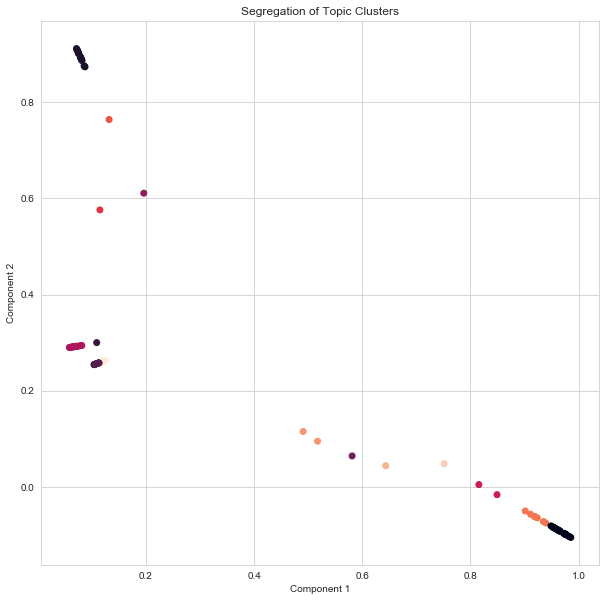

In [21]:
# Plot
plt.figure(figsize=(10, 10))
plt.scatter(x, y, c=clusters)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [22]:
# How to get similar documents for any given piece of text
# With the probability of topics for a given document (using predict_topic()),
# compute the euclidean distance with the probability scores of all other documents.
# The most similar documents are the ones with the smallest distance.

In [23]:
from sklearn.metrics.pairwise import euclidean_distances

#nlp = spacy.load('en', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = neg_reviews, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [24]:
# Get similar documents
mytext = ["Old small room"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = neg_reviews, top_n=1, verbose=True)
#print('\n', docs[0][:500])

Topic KeyWords:  ['room', 'hotel', 'bad', 'good', 'did', 'staff', 'stay', 'desk', 'old', 'motel', 'night', 'just', 'breakfast', 'didnt', 'tv']
Topic Prob Scores of text:  [[0.8 0.1 0.1 0.1]]
Most Similar Doc's Probs:   [[0.8 0.1 0.1 0.1]]
